In [1]:
#Recipe for an ML algo
# 1) Data specification (input prob, output)
# 2) cost function (metrics->cost function) + regularization
# 3) optimization procedure
# 4) Model

# In this context
1) Data specification (Input to Generator will be a 2-d tensor (noise/latent vector) and output will be the image again a 2d tensor and reverse it for discriminator however its output will be 1/0)

2) Cost function (generator: maximize the likelihood of discriminator classifying fake as real. discriminator: want to maximize the likelihood of classifying fake as fake and real as real)

3) Optimization procedure (adam,sgd)

4) Model (Design decisions : no. of layers, neurons in each, activation func(hidden+output) many more...)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [3]:
tran = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5)])
emnist_data = datasets.EMNIST(root='./data', split='balanced', download=True, transform=tran)
dataloader = DataLoader(emnist_data, batch_size=64, shuffle=True)

100%|██████████| 562M/562M [00:11<00:00, 47.0MB/s]


1) tanh() is chosen first for the generator because its bounded, symmetric output works well for image generation, based on practical success and theoretical benefits.

2) Normalization follows to match the real data (EMNIST) to the generator’s output range of [-1, 1], ensuring the discriminator learns properly.

In [21]:
class Generator(nn.Module):
  def __init__(self, in_dim, img_shape):
    super().__init__()
    self.img_shape = img_shape
    self.model = nn.Sequential(
        nn.Linear(in_dim, 256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(512,650),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(650, int(np.prod(img_shape))),
        nn.Tanh()
    )
  def forward(self,z):
    img_flat = self.model(z)
    img = img_flat.view(img_flat.size(0), *self.img_shape)
    return img

In [27]:
class Discriminator(nn.Module):
  def __init__(self, img_shape):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(int(np.prod(img_shape)),512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
  def forward(self, img):
    img_flat = img.view(img.size(0) , -1)
    label = self.model(img_flat)
    return label

In [28]:
in_dim = 128
img_shape = (1,28,28)
generator = Generator(in_dim , img_shape)
discriminator = Discriminator(img_shape)

In [29]:
#Loss Function and optimization procedure
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

#Understanding BCEloss
BCE=−[y⋅log⁡(p)+(1−y)⋅log⁡(1−p)]
here, y : label 0 or 1  and p: prob that the label is true

# In context of GAN
*For Discriminator*: first you find the loss for real images:
now for that the BCEloss reduces to : BCE=−[y⋅log⁡(p)] (Note: if p is higher like 0.9 then log(p) would give negative higher number but as we are minimizing taking negative makes it smaller relatively. Hence, less loss.)

second you  find loss for fake images: now the BCE reduces to:
BCE=−[(1)⋅log⁡(1−p)] (Note: here also p means the same. The lesser it is the lesser the loss)

*For Generator*: Generator wants to fool discriminator into classifying fake as real(1).So, the BCE in this case will be: BCE=−[y⋅log⁡(p)].
Here p = D(G(z)). Higher the p lesser will be the loss.

Improvement:

You can have some learning element by label smoothing.

Also if generator seems powerful then  adding a dropout might makes sense.

#Label smoothing
To not completely eliminate the other half of loss function

To avoid gradient vanishing problem.

[Epoch 0/44] [Batch 0/1763] [D loss: 0.6925] [G loss: 0.7034]
[Epoch 0/44] [Batch 100/1763] [D loss: 0.7194] [G loss: 0.6928]
[Epoch 0/44] [Batch 200/1763] [D loss: 0.6612] [G loss: 0.7437]
[Epoch 0/44] [Batch 300/1763] [D loss: 0.6413] [G loss: 0.8498]
[Epoch 0/44] [Batch 400/1763] [D loss: 0.6228] [G loss: 0.8607]
[Epoch 0/44] [Batch 500/1763] [D loss: 0.5270] [G loss: 1.0516]
[Epoch 0/44] [Batch 600/1763] [D loss: 0.5655] [G loss: 1.1735]
[Epoch 0/44] [Batch 700/1763] [D loss: 0.5316] [G loss: 1.8045]
[Epoch 0/44] [Batch 800/1763] [D loss: 0.4909] [G loss: 1.7325]
[Epoch 0/44] [Batch 900/1763] [D loss: 0.4884] [G loss: 1.8057]
[Epoch 0/44] [Batch 1000/1763] [D loss: 0.5038] [G loss: 1.1849]
[Epoch 0/44] [Batch 1100/1763] [D loss: 0.4503] [G loss: 1.8917]
[Epoch 0/44] [Batch 1200/1763] [D loss: 0.3491] [G loss: 2.1770]
[Epoch 0/44] [Batch 1300/1763] [D loss: 0.3605] [G loss: 2.1972]
[Epoch 0/44] [Batch 1400/1763] [D loss: 0.3197] [G loss: 2.5737]
[Epoch 0/44] [Batch 1500/1763] [D los

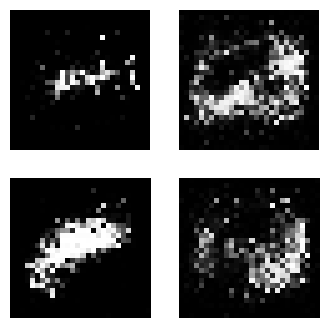

[Epoch 1/44] [Batch 0/1763] [D loss: 0.3366] [G loss: 2.1624]
[Epoch 1/44] [Batch 100/1763] [D loss: 0.4075] [G loss: 2.0261]
[Epoch 1/44] [Batch 200/1763] [D loss: 0.4460] [G loss: 2.1850]
[Epoch 1/44] [Batch 300/1763] [D loss: 0.3639] [G loss: 2.2675]
[Epoch 1/44] [Batch 400/1763] [D loss: 0.3983] [G loss: 2.5543]
[Epoch 1/44] [Batch 500/1763] [D loss: 0.3513] [G loss: 2.0117]
[Epoch 1/44] [Batch 600/1763] [D loss: 0.3665] [G loss: 2.3755]
[Epoch 1/44] [Batch 700/1763] [D loss: 0.4896] [G loss: 3.1499]
[Epoch 1/44] [Batch 800/1763] [D loss: 0.4201] [G loss: 2.6027]
[Epoch 1/44] [Batch 900/1763] [D loss: 0.3953] [G loss: 2.0059]
[Epoch 1/44] [Batch 1000/1763] [D loss: 0.4399] [G loss: 2.2899]
[Epoch 1/44] [Batch 1100/1763] [D loss: 0.3875] [G loss: 2.0795]
[Epoch 1/44] [Batch 1200/1763] [D loss: 0.6717] [G loss: 1.4112]
[Epoch 1/44] [Batch 1300/1763] [D loss: 0.4622] [G loss: 1.8060]
[Epoch 1/44] [Batch 1400/1763] [D loss: 0.4481] [G loss: 2.2049]
[Epoch 1/44] [Batch 1500/1763] [D los

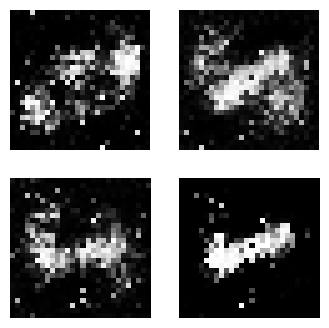

[Epoch 2/44] [Batch 0/1763] [D loss: 0.3201] [G loss: 2.6237]
[Epoch 2/44] [Batch 100/1763] [D loss: 0.4200] [G loss: 1.9015]
[Epoch 2/44] [Batch 200/1763] [D loss: 0.4050] [G loss: 2.1974]
[Epoch 2/44] [Batch 300/1763] [D loss: 0.3701] [G loss: 1.9294]
[Epoch 2/44] [Batch 400/1763] [D loss: 0.4230] [G loss: 1.6640]
[Epoch 2/44] [Batch 500/1763] [D loss: 0.3610] [G loss: 1.8929]
[Epoch 2/44] [Batch 600/1763] [D loss: 0.3268] [G loss: 2.3896]
[Epoch 2/44] [Batch 700/1763] [D loss: 0.4098] [G loss: 2.1002]
[Epoch 2/44] [Batch 800/1763] [D loss: 0.3730] [G loss: 1.8252]
[Epoch 2/44] [Batch 900/1763] [D loss: 0.3626] [G loss: 1.8584]
[Epoch 2/44] [Batch 1000/1763] [D loss: 0.3618] [G loss: 1.9712]
[Epoch 2/44] [Batch 1100/1763] [D loss: 0.4068] [G loss: 2.0821]
[Epoch 2/44] [Batch 1200/1763] [D loss: 0.5065] [G loss: 3.8173]
[Epoch 2/44] [Batch 1300/1763] [D loss: 0.4876] [G loss: 1.4377]
[Epoch 2/44] [Batch 1400/1763] [D loss: 0.3172] [G loss: 2.9735]
[Epoch 2/44] [Batch 1500/1763] [D los

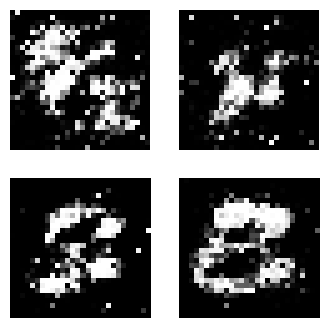

[Epoch 3/44] [Batch 0/1763] [D loss: 0.3700] [G loss: 2.3967]
[Epoch 3/44] [Batch 100/1763] [D loss: 0.4664] [G loss: 1.4949]
[Epoch 3/44] [Batch 200/1763] [D loss: 0.4093] [G loss: 3.1213]
[Epoch 3/44] [Batch 300/1763] [D loss: 0.4333] [G loss: 1.5164]
[Epoch 3/44] [Batch 400/1763] [D loss: 0.3632] [G loss: 2.2719]
[Epoch 3/44] [Batch 500/1763] [D loss: 0.4525] [G loss: 1.7006]
[Epoch 3/44] [Batch 600/1763] [D loss: 0.4439] [G loss: 1.7103]
[Epoch 3/44] [Batch 700/1763] [D loss: 0.4082] [G loss: 2.0502]
[Epoch 3/44] [Batch 800/1763] [D loss: 0.3122] [G loss: 2.7356]
[Epoch 3/44] [Batch 900/1763] [D loss: 0.4612] [G loss: 1.8538]
[Epoch 3/44] [Batch 1000/1763] [D loss: 0.3758] [G loss: 1.9877]
[Epoch 3/44] [Batch 1100/1763] [D loss: 0.5615] [G loss: 3.1121]
[Epoch 3/44] [Batch 1200/1763] [D loss: 0.3568] [G loss: 3.6524]
[Epoch 3/44] [Batch 1300/1763] [D loss: 0.5670] [G loss: 1.5952]
[Epoch 3/44] [Batch 1400/1763] [D loss: 0.3750] [G loss: 1.8565]
[Epoch 3/44] [Batch 1500/1763] [D los

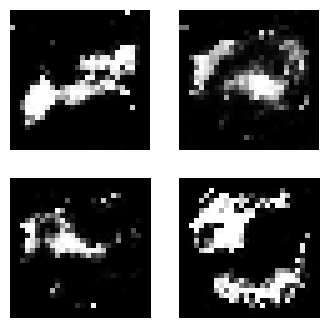

[Epoch 4/44] [Batch 0/1763] [D loss: 0.4388] [G loss: 1.8541]
[Epoch 4/44] [Batch 100/1763] [D loss: 0.4138] [G loss: 1.2765]
[Epoch 4/44] [Batch 200/1763] [D loss: 0.3517] [G loss: 2.3721]
[Epoch 4/44] [Batch 300/1763] [D loss: 0.3780] [G loss: 2.3949]
[Epoch 4/44] [Batch 400/1763] [D loss: 0.4356] [G loss: 2.1301]
[Epoch 4/44] [Batch 500/1763] [D loss: 0.3688] [G loss: 1.6962]
[Epoch 4/44] [Batch 600/1763] [D loss: 0.4241] [G loss: 1.5419]
[Epoch 4/44] [Batch 700/1763] [D loss: 0.3984] [G loss: 2.5295]
[Epoch 4/44] [Batch 800/1763] [D loss: 0.3683] [G loss: 2.0643]
[Epoch 4/44] [Batch 900/1763] [D loss: 0.4568] [G loss: 2.6270]
[Epoch 4/44] [Batch 1000/1763] [D loss: 0.4362] [G loss: 2.2322]
[Epoch 4/44] [Batch 1100/1763] [D loss: 0.3962] [G loss: 2.3717]
[Epoch 4/44] [Batch 1200/1763] [D loss: 0.4241] [G loss: 1.4989]
[Epoch 4/44] [Batch 1300/1763] [D loss: 0.4291] [G loss: 1.2898]
[Epoch 4/44] [Batch 1400/1763] [D loss: 0.6023] [G loss: 2.5471]
[Epoch 4/44] [Batch 1500/1763] [D los

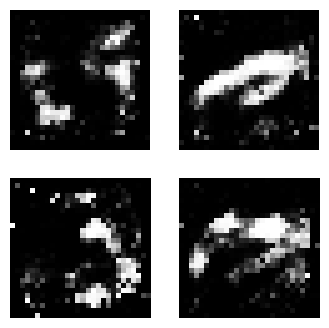

[Epoch 5/44] [Batch 0/1763] [D loss: 0.4337] [G loss: 1.8973]
[Epoch 5/44] [Batch 100/1763] [D loss: 0.4351] [G loss: 1.8175]
[Epoch 5/44] [Batch 200/1763] [D loss: 0.3783] [G loss: 2.5041]
[Epoch 5/44] [Batch 300/1763] [D loss: 0.4024] [G loss: 1.6533]
[Epoch 5/44] [Batch 400/1763] [D loss: 0.3956] [G loss: 1.7742]
[Epoch 5/44] [Batch 500/1763] [D loss: 0.4540] [G loss: 3.0494]
[Epoch 5/44] [Batch 600/1763] [D loss: 0.4056] [G loss: 2.6374]
[Epoch 5/44] [Batch 700/1763] [D loss: 0.4101] [G loss: 1.9223]
[Epoch 5/44] [Batch 800/1763] [D loss: 0.4676] [G loss: 1.2523]
[Epoch 5/44] [Batch 900/1763] [D loss: 0.5117] [G loss: 1.2020]
[Epoch 5/44] [Batch 1000/1763] [D loss: 0.5000] [G loss: 2.1003]
[Epoch 5/44] [Batch 1100/1763] [D loss: 0.4517] [G loss: 2.3212]
[Epoch 5/44] [Batch 1200/1763] [D loss: 0.4473] [G loss: 2.4865]
[Epoch 5/44] [Batch 1300/1763] [D loss: 0.4588] [G loss: 1.7293]
[Epoch 5/44] [Batch 1400/1763] [D loss: 0.4075] [G loss: 2.5563]
[Epoch 5/44] [Batch 1500/1763] [D los

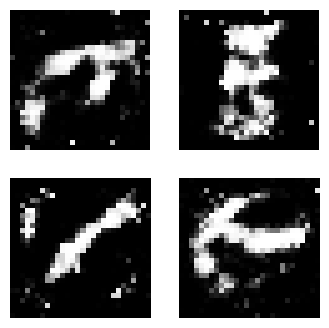

[Epoch 6/44] [Batch 0/1763] [D loss: 0.4787] [G loss: 1.7125]
[Epoch 6/44] [Batch 100/1763] [D loss: 0.3634] [G loss: 2.0783]
[Epoch 6/44] [Batch 200/1763] [D loss: 0.4268] [G loss: 1.9562]
[Epoch 6/44] [Batch 300/1763] [D loss: 0.4632] [G loss: 1.2918]
[Epoch 6/44] [Batch 400/1763] [D loss: 0.4709] [G loss: 2.1198]
[Epoch 6/44] [Batch 500/1763] [D loss: 0.4438] [G loss: 2.6107]
[Epoch 6/44] [Batch 600/1763] [D loss: 0.3999] [G loss: 2.0249]
[Epoch 6/44] [Batch 700/1763] [D loss: 0.5729] [G loss: 0.9693]
[Epoch 6/44] [Batch 800/1763] [D loss: 0.4367] [G loss: 2.5135]
[Epoch 6/44] [Batch 900/1763] [D loss: 0.5002] [G loss: 2.2575]
[Epoch 6/44] [Batch 1000/1763] [D loss: 0.4579] [G loss: 1.5276]
[Epoch 6/44] [Batch 1100/1763] [D loss: 0.4040] [G loss: 1.5431]
[Epoch 6/44] [Batch 1200/1763] [D loss: 0.4713] [G loss: 1.6595]
[Epoch 6/44] [Batch 1300/1763] [D loss: 0.5138] [G loss: 2.8145]
[Epoch 6/44] [Batch 1400/1763] [D loss: 0.4262] [G loss: 1.7598]
[Epoch 6/44] [Batch 1500/1763] [D los

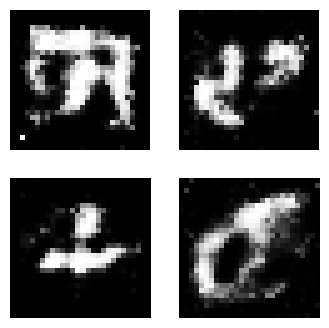

[Epoch 7/44] [Batch 0/1763] [D loss: 0.5370] [G loss: 1.4435]
[Epoch 7/44] [Batch 100/1763] [D loss: 0.5298] [G loss: 1.3520]
[Epoch 7/44] [Batch 200/1763] [D loss: 0.4612] [G loss: 1.8499]
[Epoch 7/44] [Batch 300/1763] [D loss: 0.4954] [G loss: 1.8271]
[Epoch 7/44] [Batch 400/1763] [D loss: 0.4161] [G loss: 2.1556]
[Epoch 7/44] [Batch 500/1763] [D loss: 0.4551] [G loss: 1.4752]
[Epoch 7/44] [Batch 600/1763] [D loss: 0.4070] [G loss: 2.0406]
[Epoch 7/44] [Batch 700/1763] [D loss: 0.5930] [G loss: 2.1885]
[Epoch 7/44] [Batch 800/1763] [D loss: 0.5142] [G loss: 2.6281]
[Epoch 7/44] [Batch 900/1763] [D loss: 0.5274] [G loss: 0.8364]
[Epoch 7/44] [Batch 1000/1763] [D loss: 0.5190] [G loss: 1.7589]
[Epoch 7/44] [Batch 1100/1763] [D loss: 0.4396] [G loss: 2.0147]
[Epoch 7/44] [Batch 1200/1763] [D loss: 0.5365] [G loss: 2.3497]
[Epoch 7/44] [Batch 1300/1763] [D loss: 0.4730] [G loss: 1.2944]
[Epoch 7/44] [Batch 1400/1763] [D loss: 0.5102] [G loss: 1.0550]
[Epoch 7/44] [Batch 1500/1763] [D los

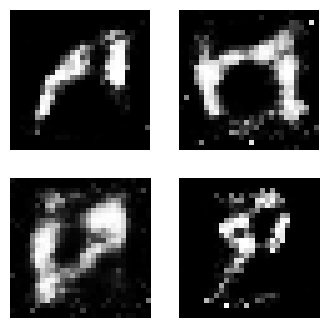

[Epoch 8/44] [Batch 0/1763] [D loss: 0.3904] [G loss: 1.6795]
[Epoch 8/44] [Batch 100/1763] [D loss: 0.4283] [G loss: 1.6182]
[Epoch 8/44] [Batch 200/1763] [D loss: 0.4297] [G loss: 1.5953]
[Epoch 8/44] [Batch 300/1763] [D loss: 0.4753] [G loss: 1.2794]
[Epoch 8/44] [Batch 400/1763] [D loss: 0.4207] [G loss: 1.8281]
[Epoch 8/44] [Batch 500/1763] [D loss: 0.5647] [G loss: 1.2941]
[Epoch 8/44] [Batch 600/1763] [D loss: 0.4639] [G loss: 1.4509]
[Epoch 8/44] [Batch 700/1763] [D loss: 0.5401] [G loss: 2.3403]
[Epoch 8/44] [Batch 800/1763] [D loss: 0.4060] [G loss: 1.5626]
[Epoch 8/44] [Batch 900/1763] [D loss: 0.5320] [G loss: 1.1336]
[Epoch 8/44] [Batch 1000/1763] [D loss: 0.4536] [G loss: 1.4762]
[Epoch 8/44] [Batch 1100/1763] [D loss: 0.4668] [G loss: 1.8646]
[Epoch 8/44] [Batch 1200/1763] [D loss: 0.7509] [G loss: 2.0103]
[Epoch 8/44] [Batch 1300/1763] [D loss: 0.4215] [G loss: 1.6743]
[Epoch 8/44] [Batch 1400/1763] [D loss: 0.5237] [G loss: 2.6170]
[Epoch 8/44] [Batch 1500/1763] [D los

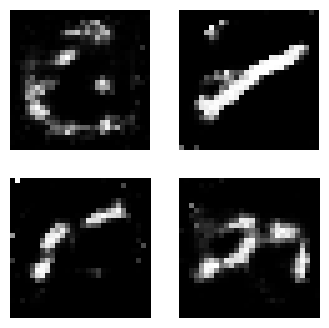

[Epoch 9/44] [Batch 0/1763] [D loss: 0.3796] [G loss: 1.8145]
[Epoch 9/44] [Batch 100/1763] [D loss: 0.4365] [G loss: 2.0739]
[Epoch 9/44] [Batch 200/1763] [D loss: 0.5188] [G loss: 1.2187]
[Epoch 9/44] [Batch 300/1763] [D loss: 0.4890] [G loss: 1.9494]
[Epoch 9/44] [Batch 400/1763] [D loss: 0.4525] [G loss: 1.4586]
[Epoch 9/44] [Batch 500/1763] [D loss: 0.4876] [G loss: 1.9556]
[Epoch 9/44] [Batch 600/1763] [D loss: 0.4456] [G loss: 1.5503]
[Epoch 9/44] [Batch 700/1763] [D loss: 0.5046] [G loss: 1.1989]
[Epoch 9/44] [Batch 800/1763] [D loss: 0.5045] [G loss: 1.5364]
[Epoch 9/44] [Batch 900/1763] [D loss: 0.5063] [G loss: 2.0830]
[Epoch 9/44] [Batch 1000/1763] [D loss: 0.4426] [G loss: 1.5927]
[Epoch 9/44] [Batch 1100/1763] [D loss: 0.4971] [G loss: 1.7266]
[Epoch 9/44] [Batch 1200/1763] [D loss: 0.4285] [G loss: 2.0017]
[Epoch 9/44] [Batch 1300/1763] [D loss: 0.4817] [G loss: 1.9122]
[Epoch 9/44] [Batch 1400/1763] [D loss: 0.4765] [G loss: 2.2775]
[Epoch 9/44] [Batch 1500/1763] [D los

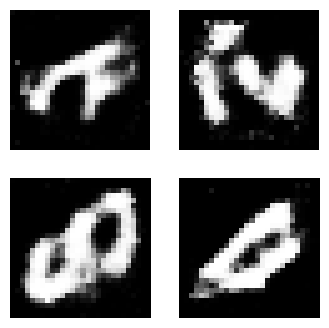

[Epoch 10/44] [Batch 0/1763] [D loss: 0.6114] [G loss: 2.0594]
[Epoch 10/44] [Batch 100/1763] [D loss: 0.5089] [G loss: 1.6721]
[Epoch 10/44] [Batch 200/1763] [D loss: 0.4657] [G loss: 2.0349]
[Epoch 10/44] [Batch 300/1763] [D loss: 0.4820] [G loss: 1.2244]
[Epoch 10/44] [Batch 400/1763] [D loss: 0.4382] [G loss: 2.2671]
[Epoch 10/44] [Batch 500/1763] [D loss: 0.4155] [G loss: 2.0497]
[Epoch 10/44] [Batch 600/1763] [D loss: 0.4800] [G loss: 1.4204]
[Epoch 10/44] [Batch 700/1763] [D loss: 0.5155] [G loss: 1.0799]
[Epoch 10/44] [Batch 800/1763] [D loss: 0.4418] [G loss: 1.9936]
[Epoch 10/44] [Batch 900/1763] [D loss: 0.4825] [G loss: 1.4736]
[Epoch 10/44] [Batch 1000/1763] [D loss: 0.4174] [G loss: 2.1279]
[Epoch 10/44] [Batch 1100/1763] [D loss: 0.4779] [G loss: 1.6332]
[Epoch 10/44] [Batch 1200/1763] [D loss: 0.4560] [G loss: 1.4317]
[Epoch 10/44] [Batch 1300/1763] [D loss: 0.3916] [G loss: 1.7946]
[Epoch 10/44] [Batch 1400/1763] [D loss: 0.4944] [G loss: 1.7880]
[Epoch 10/44] [Batch 1

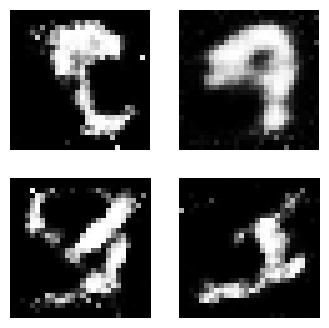

[Epoch 11/44] [Batch 0/1763] [D loss: 0.4436] [G loss: 1.8941]
[Epoch 11/44] [Batch 100/1763] [D loss: 0.5930] [G loss: 1.5445]
[Epoch 11/44] [Batch 200/1763] [D loss: 0.4471] [G loss: 1.6486]
[Epoch 11/44] [Batch 300/1763] [D loss: 0.4668] [G loss: 2.2969]
[Epoch 11/44] [Batch 400/1763] [D loss: 0.5291] [G loss: 1.9502]
[Epoch 11/44] [Batch 500/1763] [D loss: 0.4436] [G loss: 1.8100]
[Epoch 11/44] [Batch 600/1763] [D loss: 0.5340] [G loss: 1.2208]
[Epoch 11/44] [Batch 700/1763] [D loss: 0.6042] [G loss: 0.8513]
[Epoch 11/44] [Batch 800/1763] [D loss: 0.4390] [G loss: 1.5385]
[Epoch 11/44] [Batch 900/1763] [D loss: 0.4794] [G loss: 1.9442]
[Epoch 11/44] [Batch 1000/1763] [D loss: 0.6415] [G loss: 0.7549]
[Epoch 11/44] [Batch 1100/1763] [D loss: 0.4502] [G loss: 1.6516]
[Epoch 11/44] [Batch 1200/1763] [D loss: 0.4242] [G loss: 2.5201]
[Epoch 11/44] [Batch 1300/1763] [D loss: 0.4535] [G loss: 1.2319]
[Epoch 11/44] [Batch 1400/1763] [D loss: 0.4570] [G loss: 1.7273]
[Epoch 11/44] [Batch 1

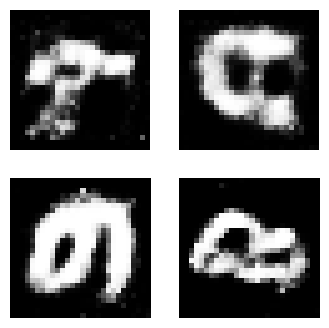

[Epoch 12/44] [Batch 0/1763] [D loss: 0.5048] [G loss: 1.0459]
[Epoch 12/44] [Batch 100/1763] [D loss: 0.4292] [G loss: 1.6168]
[Epoch 12/44] [Batch 200/1763] [D loss: 0.4336] [G loss: 1.8616]
[Epoch 12/44] [Batch 300/1763] [D loss: 0.4731] [G loss: 2.2641]
[Epoch 12/44] [Batch 400/1763] [D loss: 0.5038] [G loss: 1.3238]
[Epoch 12/44] [Batch 500/1763] [D loss: 0.4646] [G loss: 2.2283]
[Epoch 12/44] [Batch 600/1763] [D loss: 0.5035] [G loss: 1.3661]
[Epoch 12/44] [Batch 700/1763] [D loss: 0.4755] [G loss: 1.6125]
[Epoch 12/44] [Batch 800/1763] [D loss: 0.4752] [G loss: 2.5778]
[Epoch 12/44] [Batch 900/1763] [D loss: 0.4840] [G loss: 1.7082]
[Epoch 12/44] [Batch 1000/1763] [D loss: 0.5345] [G loss: 1.7296]
[Epoch 12/44] [Batch 1100/1763] [D loss: 0.4277] [G loss: 1.4727]
[Epoch 12/44] [Batch 1200/1763] [D loss: 0.4798] [G loss: 1.1536]
[Epoch 12/44] [Batch 1300/1763] [D loss: 0.4263] [G loss: 2.2590]
[Epoch 12/44] [Batch 1400/1763] [D loss: 0.5145] [G loss: 1.2085]
[Epoch 12/44] [Batch 1

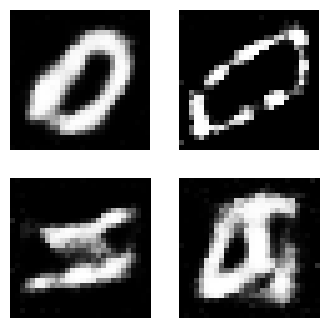

[Epoch 13/44] [Batch 0/1763] [D loss: 0.4886] [G loss: 1.7227]
[Epoch 13/44] [Batch 100/1763] [D loss: 0.4893] [G loss: 2.0644]
[Epoch 13/44] [Batch 200/1763] [D loss: 0.4695] [G loss: 1.5333]
[Epoch 13/44] [Batch 300/1763] [D loss: 0.4942] [G loss: 1.4985]
[Epoch 13/44] [Batch 400/1763] [D loss: 0.5151] [G loss: 2.4611]
[Epoch 13/44] [Batch 500/1763] [D loss: 0.4853] [G loss: 1.4281]
[Epoch 13/44] [Batch 600/1763] [D loss: 0.4570] [G loss: 1.7524]
[Epoch 13/44] [Batch 700/1763] [D loss: 0.4491] [G loss: 1.8125]
[Epoch 13/44] [Batch 800/1763] [D loss: 0.4138] [G loss: 2.1310]
[Epoch 13/44] [Batch 900/1763] [D loss: 0.4708] [G loss: 1.6432]
[Epoch 13/44] [Batch 1000/1763] [D loss: 0.4979] [G loss: 1.2559]
[Epoch 13/44] [Batch 1100/1763] [D loss: 0.5446] [G loss: 1.5352]
[Epoch 13/44] [Batch 1200/1763] [D loss: 0.4334] [G loss: 2.0385]
[Epoch 13/44] [Batch 1300/1763] [D loss: 0.4800] [G loss: 1.3182]
[Epoch 13/44] [Batch 1400/1763] [D loss: 0.4275] [G loss: 2.1467]
[Epoch 13/44] [Batch 1

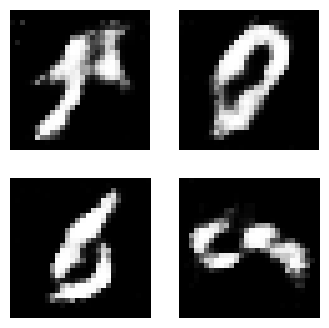

[Epoch 14/44] [Batch 0/1763] [D loss: 0.4183] [G loss: 1.9567]
[Epoch 14/44] [Batch 100/1763] [D loss: 0.6451] [G loss: 0.6190]
[Epoch 14/44] [Batch 200/1763] [D loss: 0.4824] [G loss: 1.5284]
[Epoch 14/44] [Batch 300/1763] [D loss: 0.4205] [G loss: 1.5549]
[Epoch 14/44] [Batch 400/1763] [D loss: 0.4415] [G loss: 1.9766]
[Epoch 14/44] [Batch 500/1763] [D loss: 0.4400] [G loss: 1.8263]
[Epoch 14/44] [Batch 600/1763] [D loss: 0.4892] [G loss: 1.9409]
[Epoch 14/44] [Batch 700/1763] [D loss: 0.5638] [G loss: 2.6762]
[Epoch 14/44] [Batch 800/1763] [D loss: 0.4890] [G loss: 1.3475]
[Epoch 14/44] [Batch 900/1763] [D loss: 0.4336] [G loss: 2.3555]
[Epoch 14/44] [Batch 1000/1763] [D loss: 0.5072] [G loss: 2.6221]
[Epoch 14/44] [Batch 1100/1763] [D loss: 0.4895] [G loss: 1.9092]
[Epoch 14/44] [Batch 1200/1763] [D loss: 0.5587] [G loss: 0.9195]
[Epoch 14/44] [Batch 1300/1763] [D loss: 0.4764] [G loss: 2.5804]
[Epoch 14/44] [Batch 1400/1763] [D loss: 0.4629] [G loss: 1.8544]
[Epoch 14/44] [Batch 1

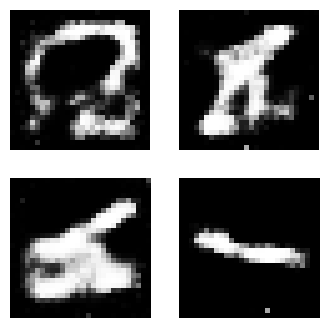

[Epoch 15/44] [Batch 0/1763] [D loss: 0.5099] [G loss: 0.9010]
[Epoch 15/44] [Batch 100/1763] [D loss: 0.4374] [G loss: 2.1909]
[Epoch 15/44] [Batch 200/1763] [D loss: 0.4433] [G loss: 1.8472]
[Epoch 15/44] [Batch 300/1763] [D loss: 0.4238] [G loss: 2.1867]
[Epoch 15/44] [Batch 400/1763] [D loss: 0.4651] [G loss: 1.3606]
[Epoch 15/44] [Batch 500/1763] [D loss: 0.4677] [G loss: 1.5351]
[Epoch 15/44] [Batch 600/1763] [D loss: 0.6228] [G loss: 2.0680]
[Epoch 15/44] [Batch 700/1763] [D loss: 0.4028] [G loss: 1.8224]
[Epoch 15/44] [Batch 800/1763] [D loss: 0.4794] [G loss: 1.0322]
[Epoch 15/44] [Batch 900/1763] [D loss: 0.4736] [G loss: 1.8347]
[Epoch 15/44] [Batch 1000/1763] [D loss: 0.4575] [G loss: 2.2037]
[Epoch 15/44] [Batch 1100/1763] [D loss: 0.5375] [G loss: 0.8200]
[Epoch 15/44] [Batch 1200/1763] [D loss: 0.4863] [G loss: 1.8846]
[Epoch 15/44] [Batch 1300/1763] [D loss: 0.4520] [G loss: 2.1576]
[Epoch 15/44] [Batch 1400/1763] [D loss: 0.4704] [G loss: 1.1424]
[Epoch 15/44] [Batch 1

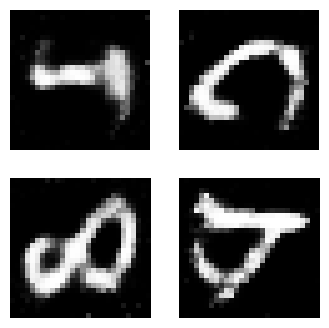

[Epoch 16/44] [Batch 0/1763] [D loss: 0.4604] [G loss: 1.7491]
[Epoch 16/44] [Batch 100/1763] [D loss: 0.4168] [G loss: 1.8025]
[Epoch 16/44] [Batch 200/1763] [D loss: 0.5080] [G loss: 1.4083]
[Epoch 16/44] [Batch 300/1763] [D loss: 0.5058] [G loss: 1.2015]
[Epoch 16/44] [Batch 400/1763] [D loss: 0.4824] [G loss: 1.6059]
[Epoch 16/44] [Batch 500/1763] [D loss: 0.5660] [G loss: 2.3788]
[Epoch 16/44] [Batch 600/1763] [D loss: 0.4125] [G loss: 2.5496]
[Epoch 16/44] [Batch 700/1763] [D loss: 0.5352] [G loss: 1.1342]
[Epoch 16/44] [Batch 800/1763] [D loss: 0.4395] [G loss: 1.4214]
[Epoch 16/44] [Batch 900/1763] [D loss: 0.5171] [G loss: 1.7518]
[Epoch 16/44] [Batch 1000/1763] [D loss: 0.4813] [G loss: 2.0255]
[Epoch 16/44] [Batch 1100/1763] [D loss: 0.4946] [G loss: 2.4641]
[Epoch 16/44] [Batch 1200/1763] [D loss: 0.4416] [G loss: 1.7066]
[Epoch 16/44] [Batch 1300/1763] [D loss: 0.4703] [G loss: 1.7383]
[Epoch 16/44] [Batch 1400/1763] [D loss: 0.4605] [G loss: 2.1993]
[Epoch 16/44] [Batch 1

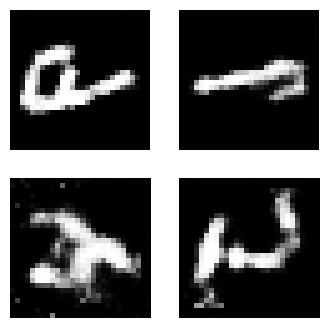

[Epoch 17/44] [Batch 0/1763] [D loss: 0.6160] [G loss: 1.8486]
[Epoch 17/44] [Batch 100/1763] [D loss: 0.4871] [G loss: 1.2211]
[Epoch 17/44] [Batch 200/1763] [D loss: 0.4736] [G loss: 1.8754]
[Epoch 17/44] [Batch 300/1763] [D loss: 0.4414] [G loss: 2.5966]
[Epoch 17/44] [Batch 400/1763] [D loss: 0.4500] [G loss: 2.1357]
[Epoch 17/44] [Batch 500/1763] [D loss: 0.5140] [G loss: 2.2491]
[Epoch 17/44] [Batch 600/1763] [D loss: 0.4332] [G loss: 1.9194]
[Epoch 17/44] [Batch 700/1763] [D loss: 0.4318] [G loss: 1.9440]
[Epoch 17/44] [Batch 800/1763] [D loss: 0.5071] [G loss: 2.1201]
[Epoch 17/44] [Batch 900/1763] [D loss: 0.5240] [G loss: 1.4242]
[Epoch 17/44] [Batch 1000/1763] [D loss: 0.4534] [G loss: 1.5277]
[Epoch 17/44] [Batch 1100/1763] [D loss: 0.4349] [G loss: 1.4955]
[Epoch 17/44] [Batch 1200/1763] [D loss: 0.5166] [G loss: 2.2109]
[Epoch 17/44] [Batch 1300/1763] [D loss: 0.5285] [G loss: 2.3367]
[Epoch 17/44] [Batch 1400/1763] [D loss: 0.4735] [G loss: 1.7673]
[Epoch 17/44] [Batch 1

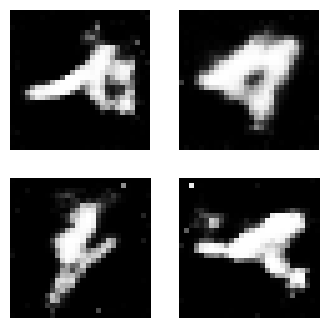

[Epoch 18/44] [Batch 0/1763] [D loss: 0.4783] [G loss: 1.2779]
[Epoch 18/44] [Batch 100/1763] [D loss: 0.4588] [G loss: 2.1182]
[Epoch 18/44] [Batch 200/1763] [D loss: 0.5615] [G loss: 2.5454]
[Epoch 18/44] [Batch 300/1763] [D loss: 0.3712] [G loss: 2.2674]
[Epoch 18/44] [Batch 400/1763] [D loss: 0.3933] [G loss: 2.4815]
[Epoch 18/44] [Batch 500/1763] [D loss: 0.4869] [G loss: 1.2706]
[Epoch 18/44] [Batch 600/1763] [D loss: 0.4923] [G loss: 1.2072]
[Epoch 18/44] [Batch 700/1763] [D loss: 0.4651] [G loss: 1.4896]
[Epoch 18/44] [Batch 800/1763] [D loss: 0.4202] [G loss: 1.8129]
[Epoch 18/44] [Batch 900/1763] [D loss: 0.4086] [G loss: 1.6305]
[Epoch 18/44] [Batch 1000/1763] [D loss: 0.4753] [G loss: 2.0361]
[Epoch 18/44] [Batch 1100/1763] [D loss: 0.5053] [G loss: 2.3912]
[Epoch 18/44] [Batch 1200/1763] [D loss: 0.4768] [G loss: 1.5198]
[Epoch 18/44] [Batch 1300/1763] [D loss: 0.4499] [G loss: 2.6832]
[Epoch 18/44] [Batch 1400/1763] [D loss: 0.4753] [G loss: 1.7748]
[Epoch 18/44] [Batch 1

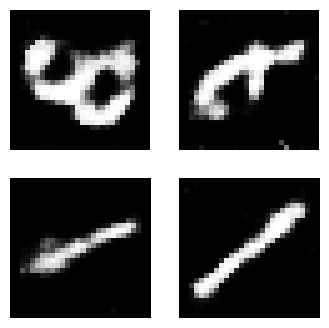

[Epoch 19/44] [Batch 0/1763] [D loss: 0.4307] [G loss: 2.2702]
[Epoch 19/44] [Batch 100/1763] [D loss: 0.4324] [G loss: 1.4723]
[Epoch 19/44] [Batch 200/1763] [D loss: 0.4836] [G loss: 2.9091]
[Epoch 19/44] [Batch 300/1763] [D loss: 0.4431] [G loss: 2.0012]
[Epoch 19/44] [Batch 400/1763] [D loss: 0.4499] [G loss: 1.9015]


In [ ]:
#Training phase
epochs = 44
for epoch in range(epochs):
    for i, (img,_) in enumerate(dataloader):
      #Train Discriminator
      real = torch.full((img.size(0),1),0.9, dtype=torch.float32) #(64,1)
      fake = torch.full((img.size(0),1),0, dtype=torch.float32) #(64,1)

      optimizer_D.zero_grad()  #for avoiding adding up grad from prev iteration
      real_loss = adversarial_loss(discriminator(img),real) #loss averaging over batches

      z = torch.randn(img.size(0), in_dim)
      gen_img = generator(z)
      fake_loss = adversarial_loss(discriminator(gen_img.detach()),fake)# maximizing the likelihood ofdiscriminator labeling a fake as fake
      D_loss = (real_loss+ fake_loss)/2
      D_loss.backward()  #calculate gradient
      optimizer_D.step() #update parameters

      #Train Generator
      optimizer_G.zero_grad()
      G_loss = adversarial_loss(discriminator(gen_img), real) #minimize the likelihood of discriminator labeling a fake as fake
      G_loss.backward()
      optimizer_G.step()

      if i % 100 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {D_loss.item():.4f}] [G loss: {G_loss.item():.4f}]")


    #for visualizing images
    with torch.no_grad():
        z = torch.randn(4, in_dim)
        gen_imgs = generator(z)
        gen_imgs = gen_imgs.detach().numpy()
        # Rescale images from [-1,1] to [0,1]
        gen_imgs = (gen_imgs + 1) / 2.0

        fig, axs = plt.subplots(2, 2, figsize=(4,4))
        cnt = 0
        for j in range(2):
            for k in range(2):
                axs[j, k].imshow(gen_imgs[cnt][0], cmap='gray')
                axs[j, k].axis('off')
                cnt += 1
        plt.show()
